In [776]:
# General libraries
import pandas as pd
import numpy as np
import copy
import pickle
import os
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from math import sqrt
from scipy.ndimage import gaussian_filter1d

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, TimeDistributed
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

In [777]:
%run utils.ipynb

In [778]:
%run preprocessing.ipynb

In [779]:
%run preparation.ipynb

In [780]:
%run training_lstm.ipynb

In [781]:
%run predict.ipynb

In [782]:
# Read training data
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [783]:
# List of parameters for preprocessing
params = [
    ['rides_not_served', 'active_customers', 'avg_actual_expected_price_60min', 'avg_actual_price_60min', 'rides_canceled', 'rides_rejections', 'rides_accepted', 'avg_actual_expected_price', 'avg_actual_price', 'avg_actual_expected_price_30min', 'avg_actual_price_30min', 'rides_requested'],
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    1, # differencing
    False, # seasonality
    True # normalize
]
scaler_path = f"df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"

# Apply preprocessing strategy according to previous parameters selection
df_ = copy.deepcopy(df)
df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True)                # Save dataset to datasets/proc

# Prepare training set for the model
train_set = preparation(df_proc,
                        window_size = 20,  # Windowing for LSTM model
                        overlap = 0,       # Number of observations to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set. After cross-validation we use all training data

(86400, 28)
(4320, 20, 28)


In [784]:
model_path = 'models/lstm/2_2_128_128_tanh_sigmoid_0_00001_500_mse_32.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)
# Predict and assess performance on training set
original, reconstructed = predict(model, train_set, scaler_path, recurrent = True)

# Save metrics plots and dataframes
num_features = min(train_set.shape[2], len(df_proc.columns))
mae_df = compute_overall_error_(original, reconstructed, df_proc.columns, num_features, df, params[0])
mae_df = mae_df[:-1].reset_index(drop = True)

135/135 [==============================] - 2s 11ms/step


/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_14265/1981921555.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1261.9966666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_true.iloc[i, j] = df_true.iloc[i-1, j] + original_features[i][j]
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_14265/1981921555.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1261.9742210581899' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pred.iloc[i, j] = df_pred.iloc[i-1, j] + reconstructed_features[i][j]
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_14265/1981921555.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '89.83

Mean MAE: 0             0.0
1        0.003156
2        0.005987
3        0.010059
4        0.012051
          ...    
7195    17.969654
7196    17.970498
7197     17.97167
7198    17.972562
7199          0.0
Length: 7200, dtype: object


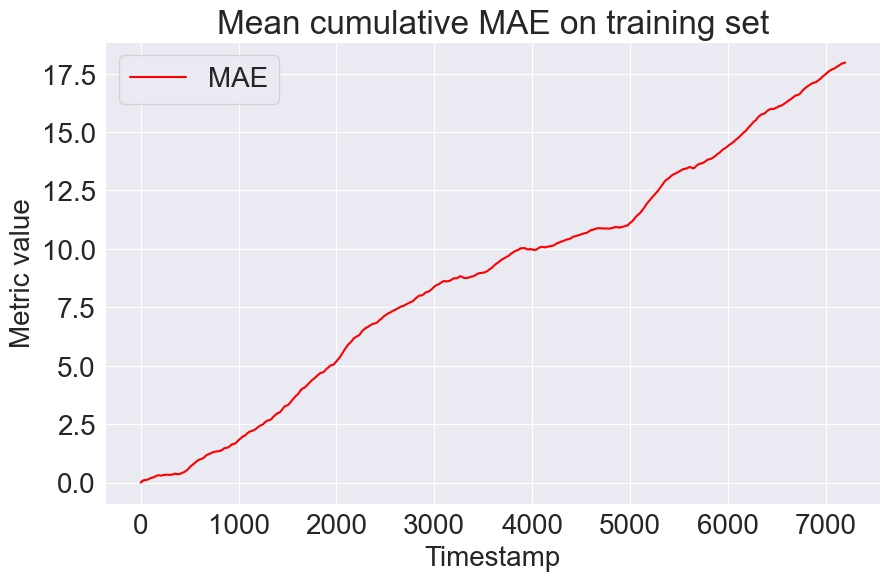

In [785]:
# Compute mean mae across columns on training set
#normalized_df=(mae_df-mae_df.min())/(mae_df.max()-mae_df.min())
mean_err_mae = mae_df.mean(axis = 1)
plt.figure(figsize = (10, 6))
plt.plot(mean_err_mae, color = 'r', label = 'MAE')
plt.title('Mean cumulative MAE on training set')
plt.xlabel('Timestamp')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

In [895]:
# Read test data
fail = 'long_rides_greedy'
hour = 'day'
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [896]:
df_fail_ = copy.deepcopy(df_fail)
# Apply preprocessing strategy according to previous parameters selection
df_proc_fail, scaler_ = preprocessing(df_fail_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = params[7],
                               seasonality = params[8],
                               normalize = params[9],
                               load_scaler = True,
                               save = False)

# Prepare test set for the model
test_set_fail = preparation(df_proc_fail,
                            window_size = 20,
                            overlap = 0,
                            val_hours = 0)

(10800, 28)
(540, 20, 28)


In [897]:
df_proc_fail_ = preprocessing(df_fail_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = 0,
                               seasonality = params[8],
                               normalize = False,
                               load_scaler = False,
                               save = False)

In [898]:
df_proc_fail_ = df_proc_fail.reset_index(drop = True)

In [899]:
# Predict and assess performance on test set
original, reconstructed = predict(model, test_set_fail, scaler_path, recurrent = True)

# Save metrics plots and dataframes
num_features = min(test_set_fail.shape[2], len(df_proc_fail.columns))
mae_fail_df = compute_overall_error__(original, reconstructed, df_proc_fail.columns, num_features, df_proc_fail_, [])
mae_fail_df = mae_fail_df[:-1].reset_index(drop = True)

17/17 [==============================] - 0s 12ms/step
Mean MAE: 0             0.0
1        0.003471
2        0.006499
3        0.008729
4        0.010253
          ...    
7196     33.21756
7197    33.223816
7198    33.229837
7199     33.23612
7200          0.0
Length: 7201, dtype: object


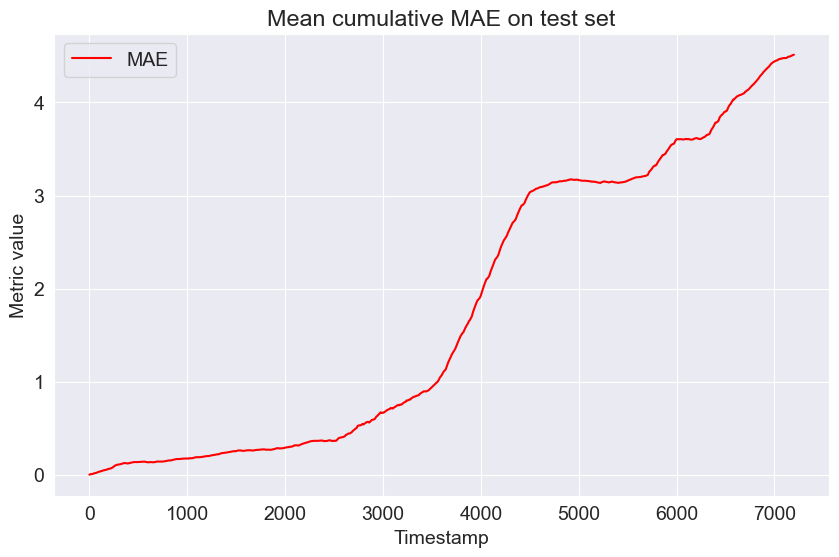

In [900]:
mae_norm = (mae_df - mae_df.min())/(mae_df.max() - mae_df.min())
mae_fail_norm = (mae_fail_df - mae_df.min())/(mae_df.max() - mae_df.min())
mae_norm = mae_norm.mean(axis = 1)
mae_fail_norm = mae_fail_norm.mean(axis = 1)
plt.figure(figsize = (10, 6))
plt.plot(mae_fail_norm, color = 'red', label = 'MAE')
plt.title('Mean cumulative MAE on test set')
plt.xlabel('Timestamp')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

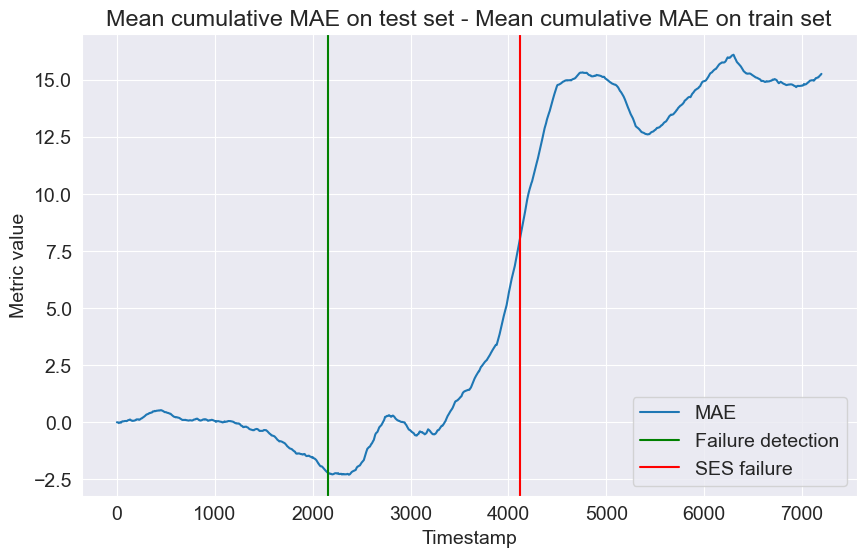

In [901]:
mean_err_mae = mae_fail_df.mean(axis = 1) - mae_df.mean(axis = 1)
plt.figure(figsize = (10, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(mean_err_mae, label = 'MAE')
plt.title('Mean cumulative MAE on test set - Mean cumulative MAE on train set')
plt.xlabel('Timestamp')
plt.ylabel('Metric value')
if 'greedy' in fail:
    fails = {'driver_strike_greedy': 1233,
             'underground_greedy': 3051,
             'long_rides_greedy': 4118,
             'flash_mob_greedy': 3689
             }
    preds = {'driver_strike_greedy': 514,
             'underground_greedy': 1298,
             'long_rides_greedy': 2160,
             'flash_mob_greedy': 660
             }
    plt.axvline(x=preds[fail], color='green', linestyle='-', label='Failure detection')
    plt.axvline(x=fails[fail], color='r', linestyle='-', label='SES failure')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

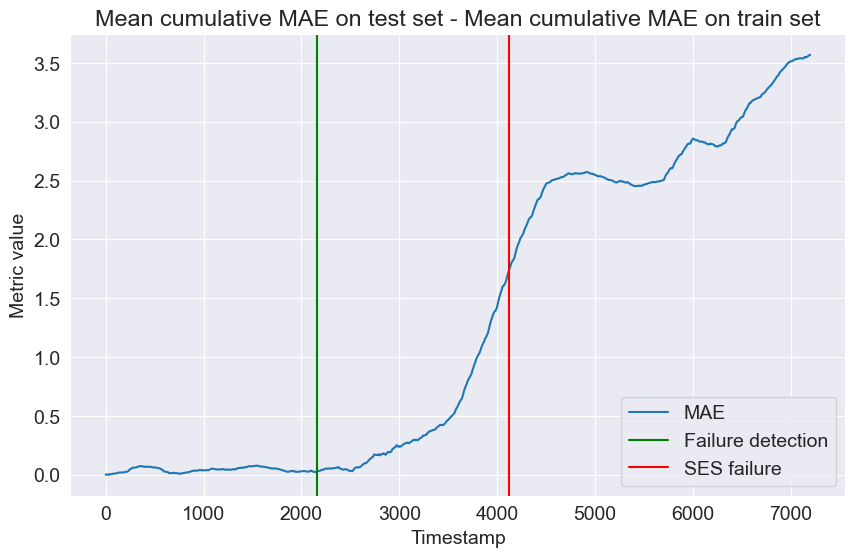

In [902]:
mae_norm = (mae_df - mae_df.min())/(mae_df.max() - mae_df.min())
mae_fail_norm = (mae_fail_df - mae_df.min())/(mae_df.max() - mae_df.min())
mae_norm = mae_norm.mean(axis = 1)
mae_fail_norm = mae_fail_norm.mean(axis = 1)
mean_err_mae = mae_fail_norm - mae_norm
plt.figure(figsize = (10, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(mean_err_mae, label = 'MAE')
plt.title('Mean cumulative MAE on test set - Mean cumulative MAE on train set')
plt.xlabel('Timestamp')
plt.ylabel('Metric value')
if 'greedy' in fail:
    fails = {'driver_strike_greedy': 1233,
             'underground_greedy': 3051,
             'long_rides_greedy': 4118,
             'flash_mob_greedy': 3689
             }
    preds = {'driver_strike_greedy': 514,
             'underground_greedy': 1298,
             'long_rides_greedy': 2160,
             'flash_mob_greedy': 660
             }
    plt.axvline(x=preds[fail], color='green', linestyle='-', label='Failure detection')
    plt.axvline(x=fails[fail], color='r', linestyle='-', label='SES failure')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

rides_in_progress: 6.854609538935205
idle_drivers: 1.3171548786199914
responding_drivers: 2.395858828413815
pickup_drivers: 1.083964843138969
on_road_drivers: 1.7877477065994365
moving_drivers: 1.270921797277324
pending_customers: 2.307140761035502
avg_rejections_before_accepted: 6.576576103593333
avg_surge_multiplier: 7.134534289899258
avg_expected_price: 8.324649431739697
avg_real_price: 11.364282747322735
avg_diff_price: 3.4461669225281866
avg_current_error_ride_distance: 14.180033756267282
avg_speed_max_speed: 1.759300172104499
avg_speed_kmh: 2.4593965178335244
avg_diff_duration_min: 1.5199687463173284
avg_expected_ride_time_min: 1.613769183355675
avg_expected_meeting_time_min: 9.854161239673239
avg_expected_total_time_min: 2.685217798823259
avg_ride_time_min: 0.5890021285244185
avg_meeting_time_min: 0.8344609599613135
avg_total_time_min: 2.9191717752652004
avg_ride_length_km: 4.547522296821549
avg_meeting_length_km: 5.026711477468351
avg_total_length_km: 4.921639466052082
avg_dist

FileNotFoundError: [Errno 2] No such file or directory: 'results/overall/long_rides_greedy_day_MAE_lstm.png'

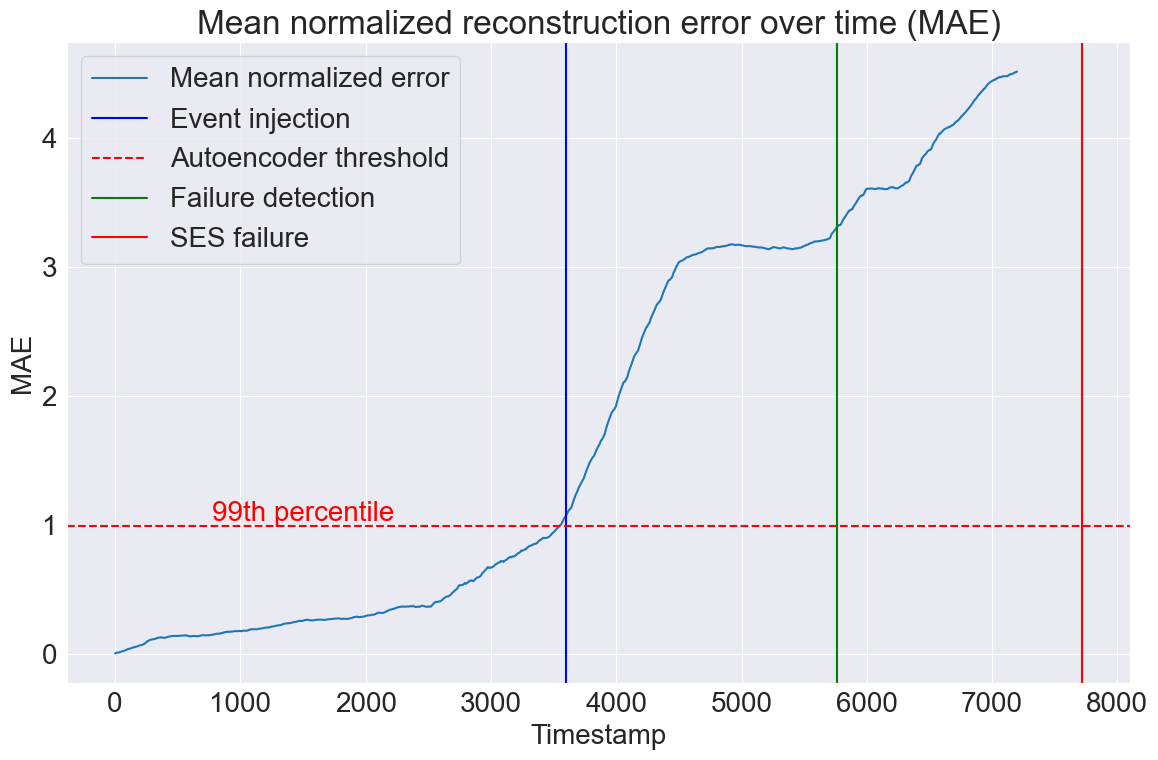

In [903]:
# Plot final results (MAE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 20})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
for indicator in mae_df.columns:
    errors = mae_df[indicator]
    errors_fail = mae_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    print(indicator + ': ' + str(max(normalized_errors)))
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
    
plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = 0.99, color = 'red', linestyle = '--', label = 'Autoencoder threshold')
if 'greedy' in fail:
    fails = {'driver_strike_greedy': 5833,
             'underground_greedy': 6651,
             'long_rides_greedy': 7718,
             'flash_mob_greedy': 6389
             }
    preds = {'driver_strike_greedy': 4114,
             'underground_greedy': 4898,
             'long_rides_greedy': 5760,
             'flash_mob_greedy': 4260
             }
    plt.axvline(x=preds[fail], color='green', linestyle='-', label='Failure detection')
    plt.axvline(x=fails[fail], color='r', linestyle='-', label='SES failure')
plt.annotate(f'99th percentile', xy = (1500, 1.03), xytext = (1500, 1.03),
             horizontalalignment = 'center', color = 'r')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/overall/' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()